# Regression case study with Bayesian Neural Networks

**Goal:** In this notebook you will investigate the advantages Bayesian NNs offer in a regression task for a Normal Distributed CPD. First, you fit a "traditional" non-Bayesian NN and then you will fit two Bayesian NN, one via *variational inference* and one via *MC-dropout*. You will compare the results of the different models, especially you will have a look at the extrapolation case.

**Usage:** The idea of the notebook is that you try to understand the provided code by running it, checking the output and playing with it by slightly changing the code and rerunning it.

**Dataset:** 
A simulated dataset with a sine wave that has a small positive linear trend and a variance that depends on the amplitude.

**Content:**
* Simulate the data set
* Fit a non-Bayesian regression model.
* Fit a Bayesian regression model via variational inference. 
* Fit a Bayesian regression model via mc dropout.
* Comparing the predictive distribution of the three approaches


| [open in colab](https://colab.research.google.com/github/tensorchiefs/dl_book/blob/master/chapter_08/nb_ch08_03.ipynb)

In [1]:
try: #If running in colab 
    import google.colab
    IN_COLAB = True 
    %tensorflow_version 2.x
except:
    IN_COLAB = False

In [2]:
import tensorflow as tf
if (not tf.__version__.startswith('2')): #Checking if tf 2.0 is installed
    print('Please install tensorflow 2.0 to run this notebook')
print('Tensorflow version: ',tf.__version__, ' running in colab?: ', IN_COLAB)

Tensorflow version:  2.7.0  running in colab?:  False


In [3]:
if IN_COLAB:
    !pip install tensorflow_probability==0.8.0

#### Imports

In [4]:
import matplotlib.pyplot as plt
import numpy as np
# from tqdm import tqdm_notebook as tqdm
import urllib.request
import tensorflow_probability as tfp


%matplotlib inline
plt.style.use('default')

tfd = tfp.distributions
tfb = tfp.bijectors
print("TFP Version", tfp.__version__)
print("TF  Version",tf.__version__)

TFP Version 0.15.0
TF  Version 2.7.0


## Data generation

Here, we use the same data generation function, that we already used in chapter 4 and in the notebook https://github.com/tensorchiefs/dl_book/blob/master/chapter_04/nb_ch04_04.ipynb 

376

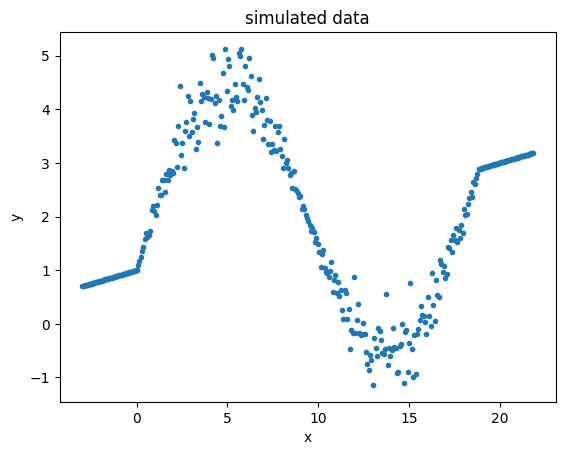

In [5]:
def create_sine_data(n = 2048):
    np.random.seed(32)
    x = np.linspace(0,1*2*np.pi,n)
    y1 = 3*np.sin(x)
    y1 = np.concatenate((np.zeros(60), y1+np.random.normal(0,0.15*np.abs(y1),n),np.zeros(60)))
    x=np.concatenate((np.linspace(-3,0,60),np.linspace(0,3*2*np.pi,n),np.linspace(3*2*np.pi,3*2*np.pi+3,60)))
    y2 = 0.1*x+1
    y=y1+y2
    return x,y

## use custom function to simulate some data 
x,y = create_sine_data(256) # Note that the model has been trained with 2048 data points
plt.scatter(x=x,y=y,marker='.',alpha=1)
plt.title("simulated data")
plt.xlabel("x")
plt.ylabel("y")
n=len(x)
n

## Non-Bayesian (just aleatoric)

We create a non-Bayesian model for the mean $\mu_x$ and the standard deviation $\sigma_x$ of a Gaussian. We use the same model, which we used in chapter https://github.com/tensorchiefs/dl_book/blob/master/chapter_04/nb_ch04_04.ipynb but this time, we define the output with tensorflow probability.

In [6]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def NLL(y, distr): 
  return -distr.log_prob(y) 

def normal_sp(params): 
  return tfd.Normal(loc=params[:,0:1], scale=1e-3 + tf.math.softplus(0.05 * params[:,1:2]))# both parameters are learnable

inputs = Input(shape=(1,))
hidden = Dense(20,activation="relu")(inputs)
hidden = Dense(50,activation="relu")(hidden)
hidden = Dense(20,activation="relu")(hidden)
params = Dense(2)(hidden)
dist = tfp.layers.DistributionLambda(normal_sp)(params) 

model_nobay = Model(inputs=inputs, outputs=dist)
model_nobay.compile(Adam(), loss=NLL) 

2021-12-14 12:30:14.343704: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-14 12:30:14.466663: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [7]:
model_nobay.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 dense (Dense)               (None, 20)                40        
                                                                 
 dense_1 (Dense)             (None, 50)                1050      
                                                                 
 dense_2 (Dense)             (None, 20)                1020      
                                                                 
 dense_3 (Dense)             (None, 2)                 42        
                                                                 
 distribution_lambda (Distri  ((None, 1),              0         
 butionLambda)                (None, 1))                         
                                                             

In [8]:
### Training takes some time
# history = model_nobay.fit(x, y, epochs=5000, verbose=0,batch_size=32)
# plt.plot(history.history['loss'])
# plt.legend(['loss'])
# plt.ylabel('NLL')
# plt.xlabel('Epochs')
# plt.show()

In [9]:
# download and load weights of the model
urllib.request.urlretrieve("https://raw.githubusercontent.com/tensorchiefs/dl_book/master/data/model_aleatoric_weights.hdf5", "model_nobay.hdf5")
model_nobay.load_weights("model_nobay.hdf5")

In [10]:
# model_nobay = Model(inputs=inputs, outputs=dist.sample())

In [11]:
x_pred = np.arange(-10,30,0.3) 
for rep in range(2): #Predictions for two runs
    print(model_nobay.predict(x_pred)[0:3].T) 

[[0.19600873 0.18531229 0.21423751]]
[[0.19065653 0.2368609  0.25677365]]


All the weights in the network are fixed. We still get different predictions for the two runs, since we sample from the Gaussian posterior. This reflects the alleatoric uncertainty. 

Now we do more runs and store the results for plotting.

In [12]:
runs = 200
nobay_cpd =np.zeros((runs,len(x_pred)))
for i in range(0,runs):
    nobay_cpd[i,:]=np.reshape(model_nobay.predict(x_pred),len(x_pred))

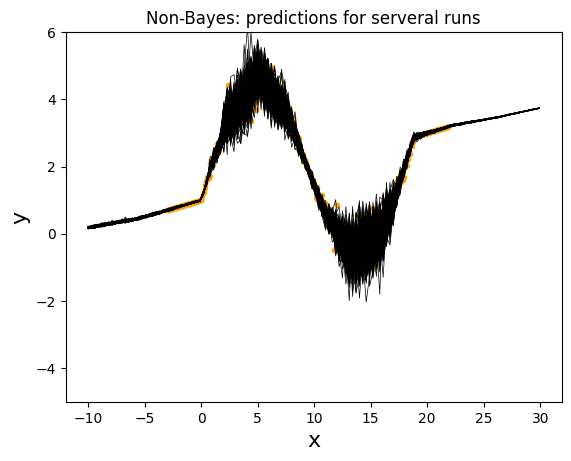

In [13]:
def make_plot_runs(ax, preds, alpha_data=1,ylim=[-7,8]):
    for i in range(0,preds.shape[0]):
      ax.plot(x_pred, preds[i],color="black",linewidth=.5)
    ax.set_ylim(ylim)
    ax.scatter(x,y,color="orange", alpha=alpha_data,marker='.') #observerd   
ax = plt.subplot()
make_plot_runs(ax, nobay_cpd)
plt.ylim([-5,6])
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
plt.title('Non-Bayes: predictions for serveral runs')
plt.show()

This plot is quite cluttered. Let's create the summary statistics to make it less cluttered.

In [14]:
np.quantile(nobay_cpd, 0.025, axis=0)

array([ 0.14942029,  0.16203772,  0.17376312,  0.19066163,  0.20861168,
        0.23275615,  0.25467253,  0.26852182,  0.29109349,  0.3037481 ,
        0.32389507,  0.34142956,  0.35336432,  0.36790342,  0.3974453 ,
        0.42133351,  0.44775619,  0.47404446,  0.50806204,  0.52426317,
        0.56408401,  0.59006186,  0.62607063,  0.65571745,  0.68492968,
        0.71071692,  0.7516196 ,  0.78051322,  0.81341925,  0.84415387,
        0.87235028,  0.90387219,  0.92966518,  0.96519073,  1.18001732,
        1.47822032,  1.8285046 ,  1.99192689,  2.2434259 ,  2.41025891,
        2.64963532,  2.7753417 ,  2.75287346,  2.83748834,  2.9975042 ,
        3.1103994 ,  3.23064277,  3.29252516,  3.47530016,  3.76755263,
        4.02718678,  4.00586085,  3.78711385,  3.69311113,  3.5932806 ,
        3.31385547,  3.29625494,  3.23232466,  3.16353398,  2.95173365,
        2.81906554,  2.63930792,  2.41703795,  2.20405225,  2.00631495,
        1.73301926,  1.44714716,  1.16077677,  0.8347055 ,  0.53

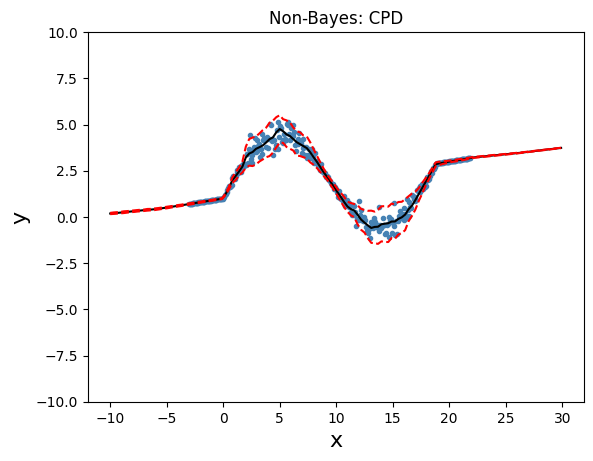

In [15]:
def make_plot_runs_avg(ax, preds, alpha_data=1,ylim=[-7,8]):
    ax.scatter(x,y,color="steelblue", alpha=alpha_data,marker='.') #observerd      
    ax.set_ylim(ylim)
    ax.plot(x_pred,np.mean(preds,axis=0),color="black",linewidth=1.5)
    ax.plot(x_pred,np.quantile(preds, 0.025, axis=0),color="red",linewidth=1.5,linestyle="--")
    ax.plot(x_pred,np.quantile(preds, 0.975, axis=0),color="red",linewidth=1.5,linestyle="--")

ax = plt.subplot()
make_plot_runs_avg(ax, nobay_cpd)
plt.ylim([-10,10])
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
plt.title('Non-Bayes: CPD')
plt.show()

## Bayesian Model using VI

Now we will train a bayesian neural network via variational inference. We again use the same architecture as above. But now instead of weights, we approximate the posterior of the weights with a normal distribution. 

The normal distribution has two paramters and therefore, we have almost doubled our paramters (we don't use a distribution for bias terms) in the network.  Because the training takes a lot of time, you will load an already trained network with the learning curve.


The model `model_vi` it self is the CPD of $y$ given by $p(y|x) = N(y,\mu_x,\sigma_x)$

In [31]:
kernel_divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(q, p) / (x.shape[0] * 1.0)
bias_divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(q, p) / (x.shape[0] * 1.0)


inputs = Input(shape=(1,))


hidden = tfp.layers.DenseFlipout(20,bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
                           bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
                           kernel_divergence_fn=kernel_divergence_fn,
                           bias_divergence_fn=bias_divergence_fn,activation="relu")(inputs)
hidden = tfp.layers.DenseFlipout(50,bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
                           bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
                           kernel_divergence_fn=kernel_divergence_fn,
                           bias_divergence_fn=bias_divergence_fn,activation="relu")(hidden)
hidden = tfp.layers.DenseFlipout(20,bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
                           bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
                           kernel_divergence_fn=kernel_divergence_fn,
                           bias_divergence_fn=bias_divergence_fn,activation="relu")(hidden)
params = tfp.layers.DenseFlipout(2,bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
                           bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
                           kernel_divergence_fn=kernel_divergence_fn,
                           bias_divergence_fn=bias_divergence_fn)(hidden)
dist = tfp.layers.DistributionLambda(normal_sp)(params) 


model_vi = Model(inputs=inputs, outputs=dist)
model_vi.compile(Adam(learning_rate=0.0002), loss=NLL) 

model_params = Model(inputs=inputs, outputs=params)

/opt/anaconda3/envs/env-hurr-tfp/lib/python3.9/site-packages/tensorflow_probability/python/layers/util.py:95: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  loc = add_variable_fn(
/opt/anaconda3/envs/env-hurr-tfp/lib/python3.9/site-packages/tensorflow_probability/python/layers/util.py:105: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  untransformed_scale = add_variable_fn(


In [17]:
model_vi.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 dense_flipout (DenseFlipout  (None, 20)               80        
 )                                                               
                                                                 
 dense_flipout_1 (DenseFlipo  (None, 50)               2100      
 ut)                                                             
                                                                 
 dense_flipout_2 (DenseFlipo  (None, 20)               2040      
 ut)                                                             
                                                                 
 dense_flipout_3 (DenseFlipo  (None, 2)                84        
 ut)                                                       

In [18]:
# from time import time
# start = time()
# Note that the model has been trained with 2048 data points
# history = model_vi.fit(x, y, epochs=20000, verbose=0,batch_size=512)
# print('time taken : ',np.round(time() - start,3)) #468 sec
# model_vi.save_weights('model_vi.hdf5')
# plt.plot(history.history['loss'])
# plt.legend(['loss'])
# plt.ylabel('NLL')
# plt.xlabel('Epochs')
# plt.ylim([0,20])
# model_vi.save_weights('model_vi.hdf5')
# plt.show()

In [19]:
# download and load weights of the model
urllib.request.urlretrieve("https://raw.githubusercontent.com/tensorchiefs/dl_book/master/data/model_vi.hdf5", "model_vi.hdf5")
model_vi.load_weights("model_vi.hdf5")

In [20]:
for rep in range(2):
    print(model_vi.predict(x_pred)[0:3].T) #Samples from the posteriori predictive distribution, different for each run

[[2.860867   0.35685197 0.72659147]]
[[0.89404374 0.89421743 2.3506784 ]]


In the next cell you can see that you also get a different prediction for the parameters, mean $\mu$ and standarddev $\sigma$ changes a bit. 

In [21]:
for rep in range(2):
    print(model_params.predict(x_pred)[0:3].T) #Samples from the parameters for the post predictive, different for each run

[[-8.3300084e-02  8.5521734e-01  7.1178710e-01]
 [-8.7970749e+01 -2.1170391e+01 -7.3017052e+01]]
[[  4.187588    3.717784    0.6982656]
 [-42.93653   -80.35977   -97.806526 ]]


### The CPD for several runs

Let's draw samples form the CPD, which we need for the plot below.

In [22]:
vi_cpd =np.zeros((runs,len(x_pred)))
for i in range(0,runs):
    vi_cpd[i,:]=np.reshape(model_vi.predict(x_pred),len(x_pred))

## MC Dropout

We repeat the analysis from above but this time using MC-Dropout instead of VI. And compare the results with the VI Bayesian network and the non-Bayesian network.

In [23]:
def normal_exp(params): 
  return tfd.Normal(loc=params[:,0:1], scale=tf.math.exp(params[:,1:2]))# both parameters are learnable

In [24]:
from tensorflow.keras.layers import Dropout

inputs = Input(shape=(1,))
hidden = Dense(200,activation="relu")(inputs)
hidden = Dropout(0.1)(hidden, training=True)
hidden = Dense(500,activation="relu")(hidden)
hidden = Dropout(0.1)(hidden, training=True)
hidden = Dense(500,activation="relu")(hidden)
hidden = Dropout(0.1)(hidden, training=True)
hidden = Dense(500,activation="relu")(hidden)
hidden = Dropout(0.1)(hidden, training=True)
hidden = Dense(200,activation="relu")(hidden)
hidden = Dropout(0.1)(hidden, training=True)
params_mc = Dense(2)(hidden)
dist_mc = tfp.layers.DistributionLambda(normal_exp, name='normal_exp')(params_mc) 

model_mc = Model(inputs=inputs, outputs=dist_mc)
model_mc.compile(Adam(learning_rate=0.0002), loss=NLL) 

In [25]:
model_mc.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 dense_4 (Dense)             (None, 200)               400       
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense_5 (Dense)             (None, 500)               100500    
                                                                 
 dropout_1 (Dropout)         (None, 500)               0         
                                                                 
 dense_6 (Dense)             (None, 500)               250500    
                                                                 
 dropout_2 (Dropout)         (None, 500)               0   

In [26]:
# from time import time
# start = time()
# Note that the model has been trained with 2048 data points
# history = model_mc.fit(x, y, epochs=1000, verbose=0,batch_size=512)
# print('time taken : ',np.round(time() - start,3)) #468 sec
# model_vi.save_weights('model_mc.hdf5')
# plt.plot(history.history['loss'])
# plt.legend(['loss'])
# plt.ylabel('NLL')
# plt.xlabel('Epochs')
# plt.ylim([0,20])
# plt.show()

In [27]:
# download and load weights of the model
urllib.request.urlretrieve("https://raw.githubusercontent.com/tensorchiefs/dl_book/master/data/model_mc.hdf5", "model_mc.hdf5")
model_mc.load_weights("model_mc.hdf5")

In [28]:
mc_cpd =np.zeros((runs,len(x_pred)))
for i in range(0,runs):
    mc_cpd[i,:]=np.reshape(model_mc.predict(x_pred),len(x_pred))

## Summary
Now, we can summerize the three approaches.

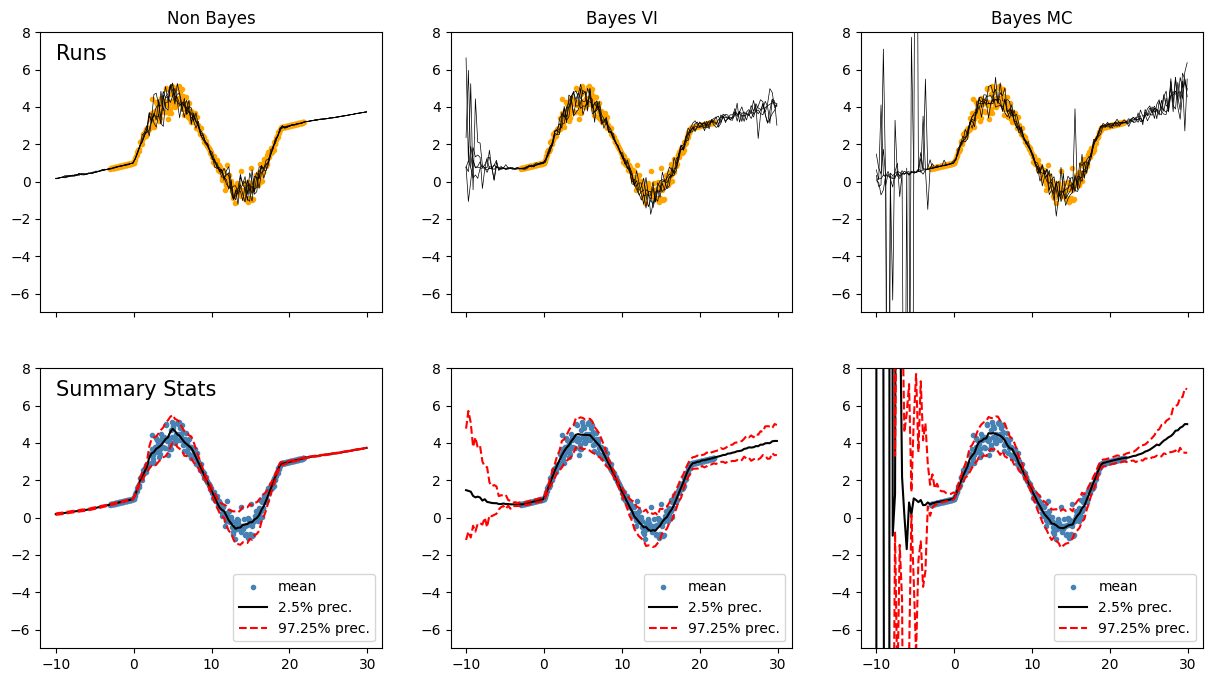

In [29]:
#plt.figure(figsize=(5,25))
f,ax = plt.subplots(2,3,sharex=True, sharey=False,figsize=(15,8))

lines = 5

make_plot_runs(ax[0,0], nobay_cpd[0:lines])
#make_no_bayes_plot(ax[0,1], model_nobay_mean, model_nobay_sd, add_std=False,ylim=[-7,8])
ax[0,0].set_title('Non Bayes')
make_plot_runs_avg(ax[1,0],nobay_cpd)
ax[1,0].legend(('mean','2.5% prec.','97.25% prec.'), loc='lower right')

ax[0,1].set_title('Bayes VI')
make_plot_runs(ax[0,1], vi_cpd[0:lines], ylim=[-7,8])
make_plot_runs_avg(ax[1,1], vi_cpd, ylim=[-7,8])
ax[1,1].legend(('mean','2.5% prec.','97.25% prec.'), loc='lower right')

ax[0,2].set_title('Bayes MC')
make_plot_runs(ax[0,2], mc_cpd[0:lines], ylim=[-7,8])
make_plot_runs_avg(ax[1,2], mc_cpd, ylim=[-7,8])
ax[1,2].legend(('mean','2.5% prec.','97.25% prec.'), loc='lower right')

#ax[0,0].axis('off')
ax[0,0].text(-10,6.5, "Runs",fontsize=15,horizontalalignment='left')

#ax[1,0].axis('off')
ax[1,0].text(-10,6.5, "Summary Stats",fontsize=15,horizontalalignment='left')


plt.savefig('ch08_good_cpd.pdf')

plt.show()